<a href="https://colab.research.google.com/github/nhonphan7/pnam/blob/main/recid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import os
import pysr
import sympy
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sys.path.append('../')
from pnam.utils.plot import *
from pnam.utils.sr import *
from pnam.wrapper import PNAMBase

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/Users/nhonphan/Downloads/Projects/projected_nam_2025/src/examples/../pnam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
data_path = '../../data/recid.data'

In [ ]:
small_size = 16
large_size = 24
plt.rc('font', size=small_size)
plt.rc('axes', labelsize=large_size)

In [ ]:
# time = datetime.datetime.now().isoformat()
time = '2025-06-08T15:55:07.578321'

In [ ]:
plot_dir = f'{time}/figures'
os.makedirs(plot_dir, exist_ok=True)

In [ ]:
df = pd.read_csv(data_path, sep=r'\s+', header=None)
df.columns = [
    'Age',
    'Race',
    'Gender',
    'Prior counts',
    'Length of stay',
    'Charge degree',
    'Recidivism risk'
]

In [ ]:
binary = ['Gender', 'Charge degree']
other = ['Age', 'Race', 'Prior counts', 'Length of stay']

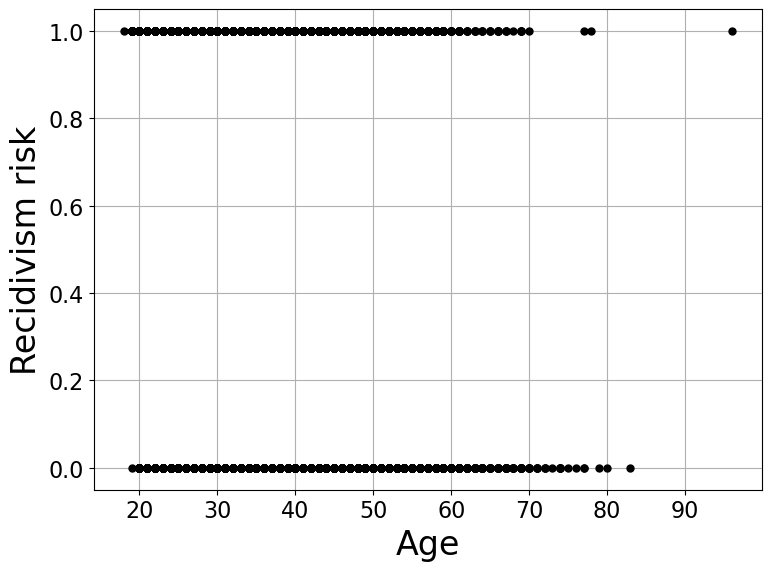

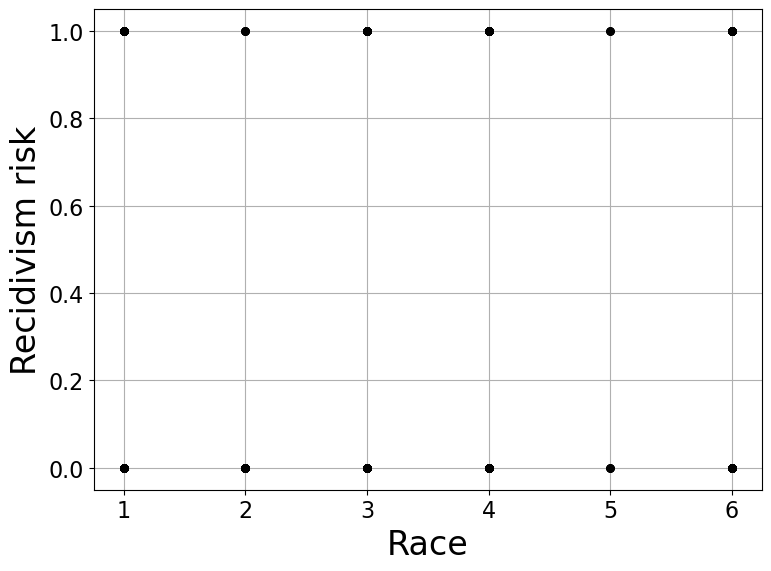

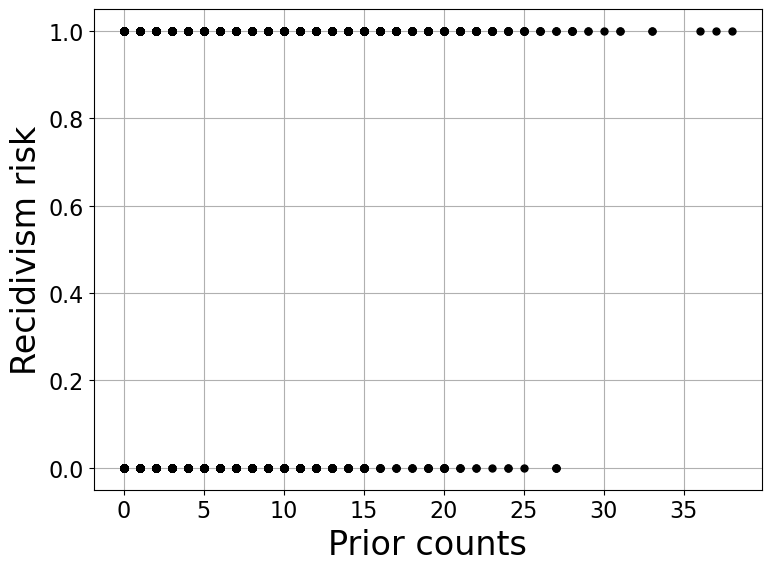

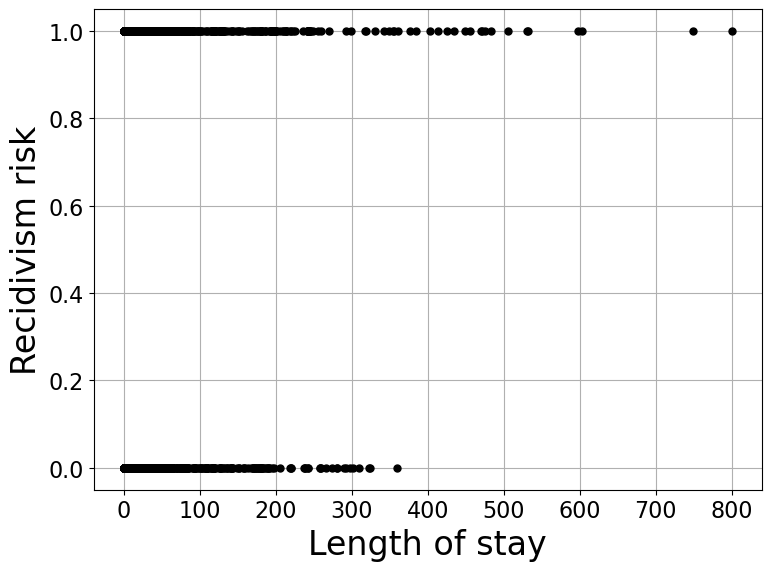

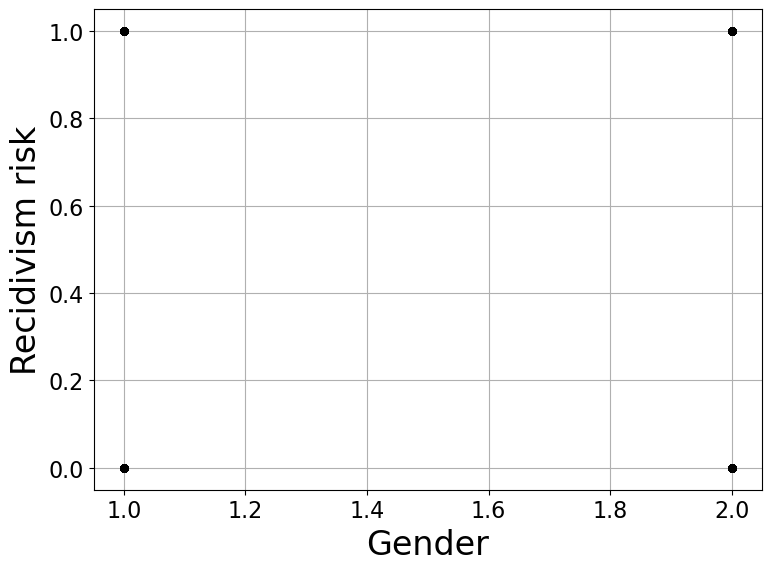

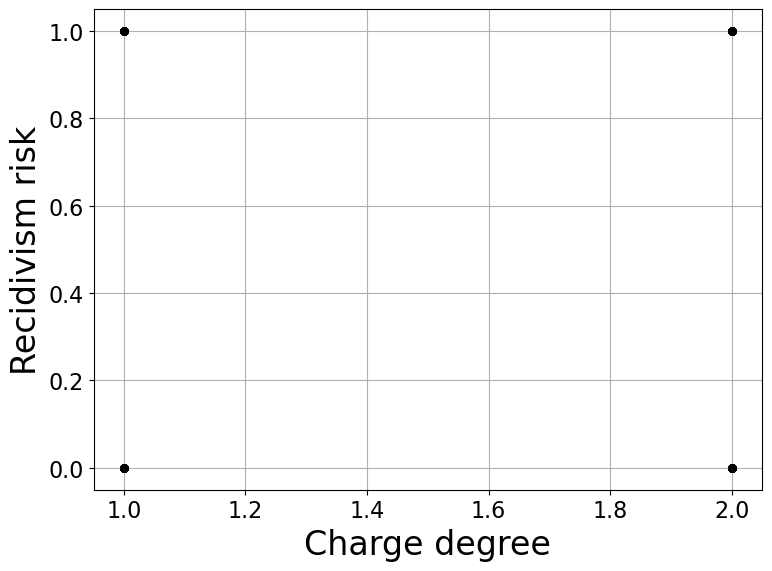

In [ ]:
plot_vars(
    df[other + binary].to_numpy(),
    df['Recidivism risk'].to_numpy(),
    other + binary,
    ['Recidivism risk']
)

In [ ]:
scaler = MinMaxScaler((-1, 1))
df[other] = scaler.fit_transform(df[other])
df[binary] = df[binary] - 1

In [ ]:
random_state = 42
data_train, data_test = train_test_split(
    df, test_size=0.2, random_state=random_state
)
X_train, y_train = data_train[other + binary], data_train['Recidivism risk']
X_test, y_test = data_test[other + binary], data_test['Recidivism risk']

In [ ]:
pnam = True
proj_size = X_train.shape[1]
num_outputs = 1
metric = 'auroc'
sobolev = False
model_idx = 0
weight_thresh = 0.2
proj_mat_thresh = 0.2
num_sr_points = 1000

In [ ]:
model_pnam = PNAMBase(
    random_state=random_state,
    num_learners=1,
    pnam=pnam,
    std=0.,
    proj_size=proj_size,
    hidden_sizes=[64, 32],
    num_outputs=num_outputs,
    activation=F.silu,
    dropout=0.,
    feature_dropout=0.,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    regression=False,
    rot_mats_reg=0.01,
    proj_mat_reg=0.01,
    sparsity_reg=0.01,
    output_reg=0.01,
    l2_reg=0.01,
    metric=metric,
    scale=True,
    sobolev=sobolev,
    val_split=0.2,
    n_jobs=1,
    batch_size=256,
    log_dir=f'{time}/pnam',
    lr=0.001,
    decay_step=1,
    decay_rate=0.995,
    num_epochs=1000,
    energy=False,
    patience=50
)

In [ ]:
# model_pnam.fit(X_train, y_train)
model_pnam.load_checkpoints(f'{time}/pnam')

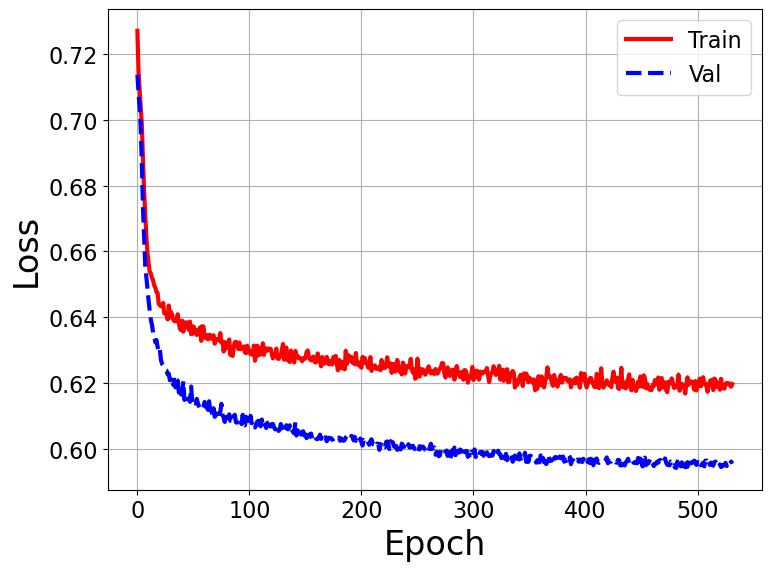

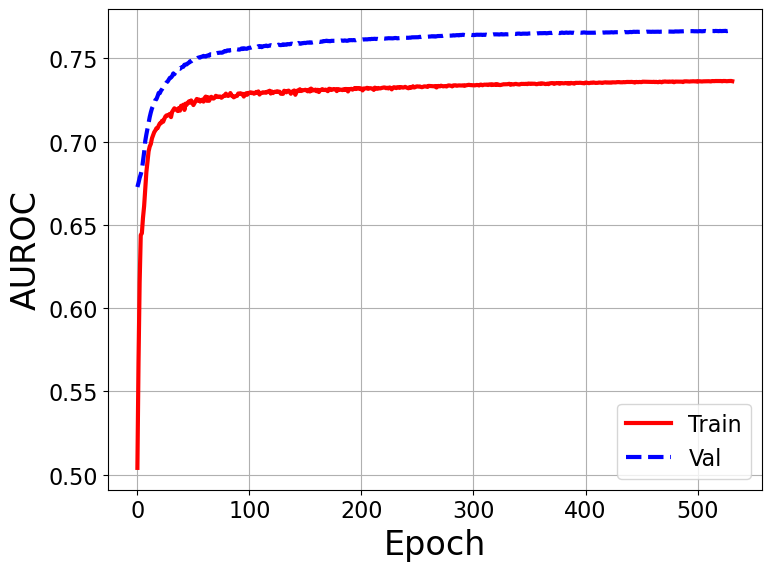

In [ ]:
plot_loss_or_metric(time, model_idx, 'loss', semilogy=False)
plot_loss_or_metric(time, model_idx, metric, semilogy=False)

In [ ]:
(
    preds_test, feats_out_test, feats_in_test, weight, bias, proj_mat, grad_in_test
) = model_pnam.predict(X_test, y_test, model_idx)

Loss: 0.6113378406
Auroc: 0.7179682029


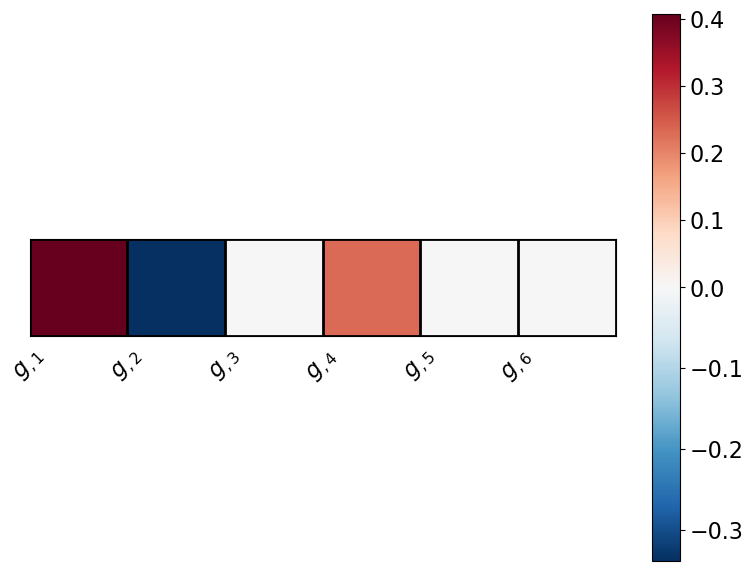

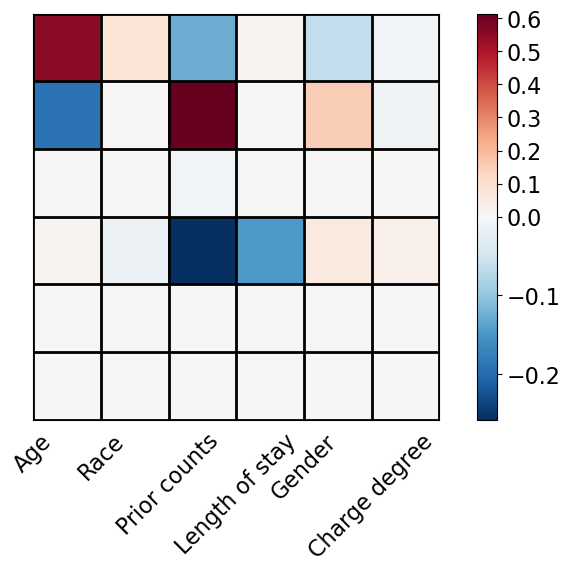

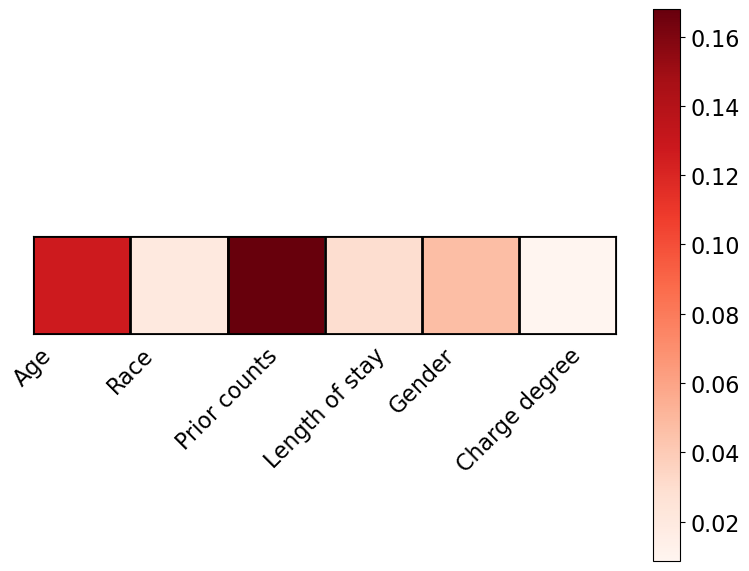

In [ ]:
plot_weight(
    weight,
    'RdBu_r',
    labels=[r'$g_{,%s}$' % (i + 1) for i in range(proj_size)],
    colorbar=True
)
plot_weight(proj_mat, 'RdBu_r', labels=other + binary, colorbar=True)
plot_weight(
    np.mean(abs(proj_mat), axis=0, keepdims=True),
    'Reds',
    labels=other + binary,
    colorbar=True
)

In [ ]:
weight_zero = np.copy(weight)
weight_zero[abs(weight_zero) < weight_thresh] = 0.
weight_zero_mean = np.mean(abs(weight_zero), axis=0, keepdims=True)

In [ ]:
proj_mat_zero = np.copy(proj_mat)
for i in range(proj_size):
    if weight_zero_mean[0, i] == 0:
        proj_mat_zero[i] = 0.
proj_mat_zero[abs(proj_mat_zero) < proj_mat_thresh] = 0.

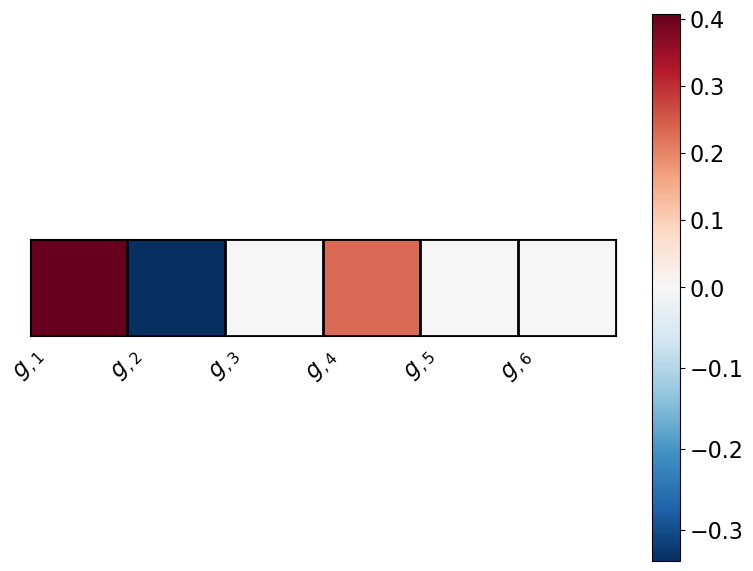

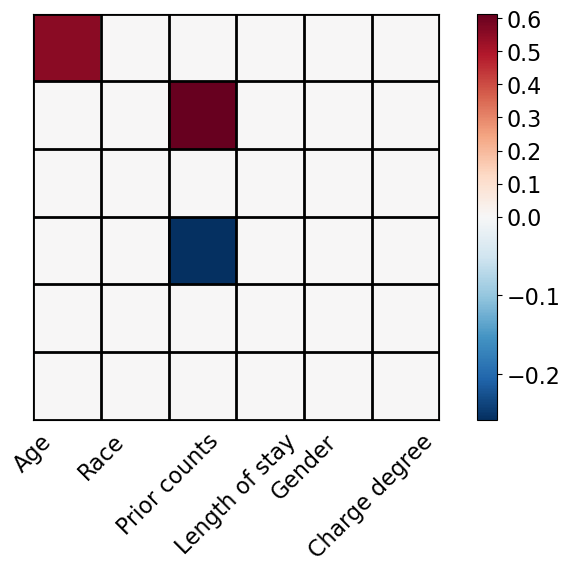

In [ ]:
plot_weight(
    weight_zero,
    'RdBu_r',
    labels=[r'$g_{,%s}$' % (i + 1) for i in range(proj_size)],
    colorbar=True
)
plot_weight(proj_mat_zero, 'RdBu_r', labels=other + binary, colorbar=True)

In [ ]:
(
    preds_test, feats_out_test, feats_in_test, _, _, _, grad_in_test
) = model_pnam.predict(X_test, y_test, model_idx, weight_zero, proj_mat_zero)

Loss: 0.6236803532
Auroc: 0.7156964161


In [ ]:
num_train_points = X_train.shape[0]
np.random.seed(random_state)
sr_indices = np.random.choice(num_train_points, num_sr_points, replace=False)
X_sr = X_train.to_numpy()[sr_indices]
y_sr = y_train.to_numpy()[sr_indices]

In [ ]:
preds_sr, feats_out_sr, feats_in_sr, _, _, _, grad_in_sr = model_pnam.predict(
    X_sr, y_sr, model_idx, weight_zero, proj_mat_zero
)

Loss: 0.5938900113
Auroc: 0.7561339101


In [ ]:
if sobolev:
    pysr.jl.seval('''
    import Pkg
    Pkg.add("Zygote")
    ''')
    pysr.jl.seval('import Zygote')

    objective = '''
    function my_custom_objective(
        tree, dataset::Dataset{T, L}, options
    )::L where {T, L}
        pred, grad, flag = eval_diff_tree_array(tree, dataset.X, options, 1)
        !flag && return L(Inf)
        pred_diff = pred .- dataset.y
        grad_diff = grad .- dataset.weights
        return (sum(pred_diff.^2) + sum(grad_diff.^2)) / length(pred_diff)
    end
    '''

In [ ]:
model_sr = pysr.PySRRegressor(
    binary_operators=['+', '*', '^'],
    unary_operators=['exp', 'cosh', 'softplus(x) = log(1 + exp(x))'],
    maxsize=30,
    niterations=10000000,
    populations=30,
    population_size=30,
    ncycles_per_iteration=500,
    elementwise_loss='L2DistLoss()',
    loss_function=objective if sobolev else None,
    model_selection='best',
    constraints={'^': (-1, 1)},
    nested_constraints={
        'exp': {'exp': 0, 'cosh': 0, 'softplus': 0},
        'cosh': {'exp': 0, 'cosh': 0, 'softplus': 0},
        'softplus': {'exp': 0, 'cosh': 0, 'softplus': 0}
    },
    complexity_of_operators={'softplus': 4},
    timeout_in_seconds=10.,
    autodiff_backend='Zygote' if sobolev else None,
    output_directory=f'{time}/sr',
    extra_sympy_mappings={'softplus': lambda x: sympy.log(1. + sympy.exp(x))}
)

In [ ]:
g_sr, gp_sr, gpp_sr = train_or_evaluate_all(
    time,
    sobolev,
    weight_zero,
    feats_out_sr,
    feats_in_sr,
    grad_in_sr,
    feats_out_test,
    feats_in_test,
    grad_in_test,
    model_sr,
    train=False
)

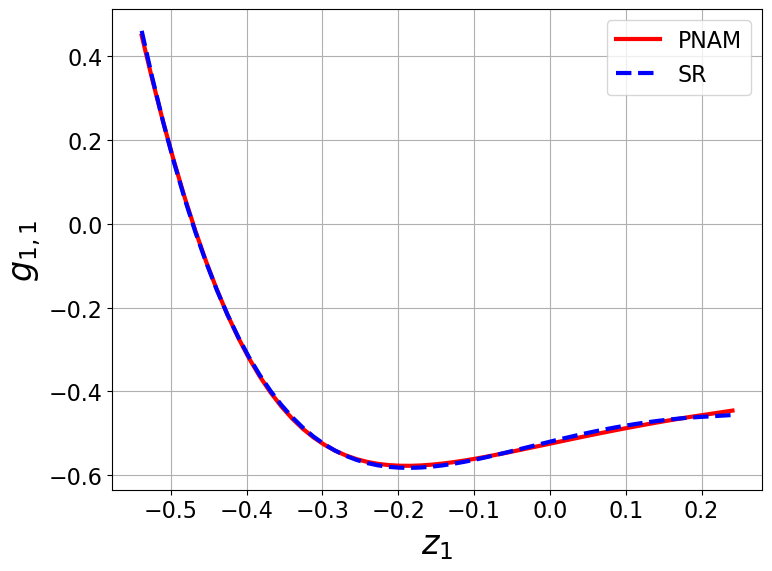

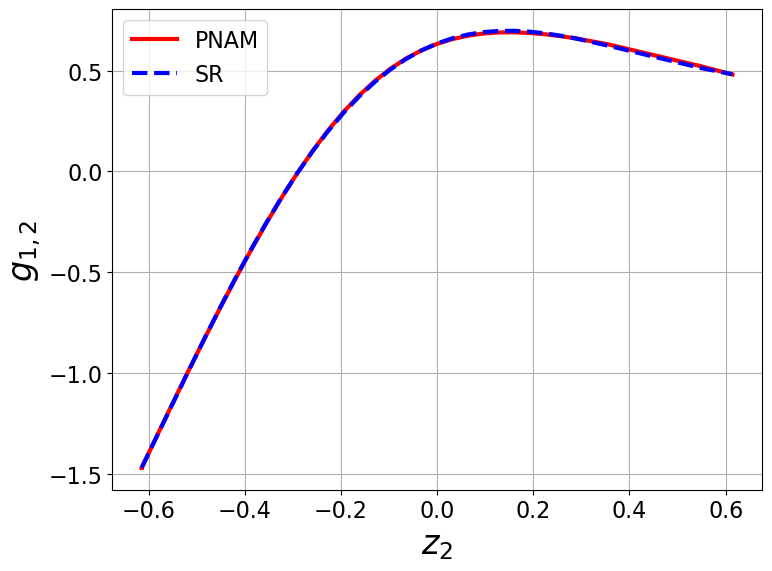

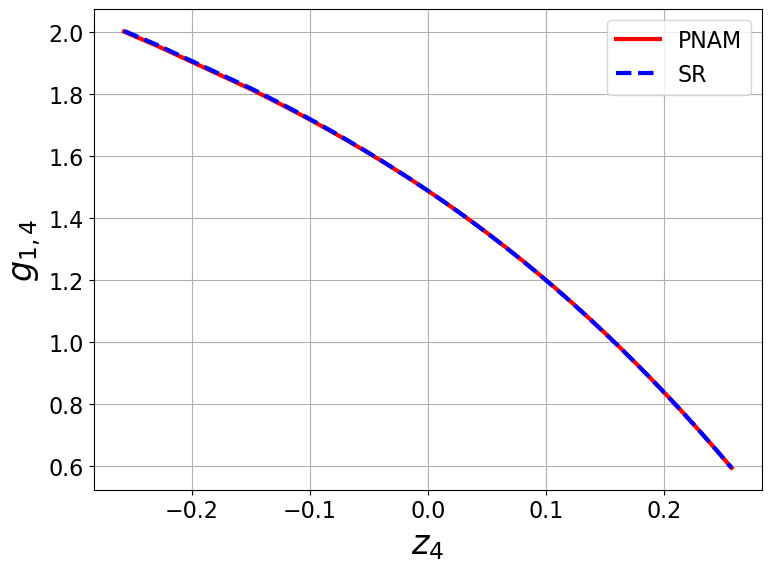

In [ ]:
for i in range(num_outputs):
    for j in range(proj_size):
        if weight_zero[i, j] == 0:
            continue
        plot_g_vs_z(feats_in_test, feats_out_test, g_sr, i, j)
        if sobolev:
            plot_g_vs_z(feats_in_test, grad_in_test, gp_sr, i, j)

In [ ]:
X_scale_ = np.concatenate((scaler.scale_, [1., 1.]))
X_min_ = np.concatenate((scaler.min_, [-1., -1.]))

In [ ]:
f = combine_eqs(time, weight_zero, bias, proj_mat_zero, 0, X_scale_, X_min_)
f_latex, f_pred = evaluate_eq(
    f, (X_test.to_numpy() - X_min_) / X_scale_, weight_zero, proj_mat_zero, 0
)
auroc = sk_metrics.roc_auc_score(y_test.to_numpy(), f_pred)
print(f_latex)
print(auroc)

0.013 x_{3} + \left(0.258 - 0.014 x_{3}\right) \left(0.039 x_{3} - 0.19 \left(1 - 0.053 x_{3}\right)^{2} \cdot \left(1.014 - 0.014 x_{3}\right) \left(0.024 x_{3} + 0.813\right) \cosh{\left(0.014 x_{3} - 0.258 \right)} - 3.306\right) + \left(0.176 x_{3} - 1.526\right) e^{- 0.052 x_{3} - \left(0.032 x_{3} - 0.247\right) \left(0.052 x_{3} - 0.995\right)} + \left(0.446 \cdot 0.232^{0.014 x_{1} - 0.807} \cdot \left(0.028 x_{1} - 1.615\right) \left(0.652 \left(0.018 x_{1} - 1\right)^{2} \cdot \left(0.042 x_{1} - 4.118\right) + 0.288\right) - 0.06\right) e^{0.014 x_{1}} + 1.215
0.7151049292337727


$0.013 x_{3} + \left(0.258 - 0.014 x_{3}\right) \left(0.039 x_{3} - 0.19 \left(1 - 0.053 x_{3}\right)^{2} \cdot \left(1.014 - 0.014 x_{3}\right) \left(0.024 x_{3} + 0.813\right) \cosh{\left(0.014 x_{3} - 0.258 \right)} - 3.306\right) + \left(0.176 x_{3} - 1.526\right) e^{- 0.052 x_{3} - \left(0.032 x_{3} - 0.247\right) \left(0.052 x_{3} - 0.995\right)} + \left(0.446 \cdot 0.232^{0.014 x_{1} - 0.807} \cdot \left(0.028 x_{1} - 1.615\right) \left(0.652 \left(0.018 x_{1} - 1\right)^{2} \cdot \left(0.042 x_{1} - 4.118\right) + 0.288\right) - 0.06\right) e^{0.014 x_{1}} + 1.215$